# Import packages

In [20]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from string import punctuation

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

ImportError: cannot import name 'tensor' from 'tensorflow.python.framework' (/Users/pippalin/anaconda3/lib/python3.11/site-packages/tensorflow/python/framework/__init__.py)

In [6]:
# 查看当前路径下的文件
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./glove.twitter.27B.100d.txt
./Fake.csv
./glove.twitter.27B.50d.txt
./NLP深度学习项目实战.docx
./glove.twitter.27B.25d.txt
./glove.twitter.27B.200d.txt
./True.csv
./NLP实战-真假新闻识别.ipynb
./NLP深度学习项目实战.pdf
./.ipynb_checkpoints/NLP实战-真假新闻识别-checkpoint.ipynb


In [3]:
true = pd.read_csv("True.csv")
fake = pd.read_csv("Fake.csv")

In [4]:
true.shape, fake.shape

((21417, 4), (23481, 4))

In [5]:
true.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [6]:
true.dtypes  # 字段类型

title      object
text       object
subject    object
date       object
dtype: object

In [7]:
true.isnull().sum()   # 查看字段的缺失值情况

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
true["category"] = 1  # 类别标签
fake["category"] = 0

两份数据的合并：

In [10]:
df = pd.concat([true, fake])
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


查看真假数据量大小：

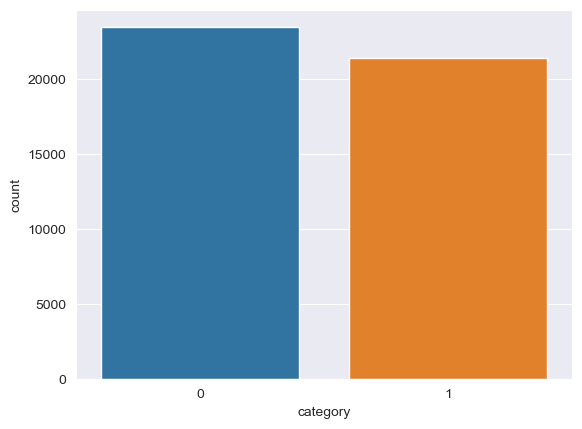

In [11]:
sns.set_style("darkgrid")

sns.countplot(df.category)

plt.show()

# 数据探索

In [12]:
#1.新闻标题的总数
df.title.count()

44898

In [13]:
#2.新闻主题的分类数量
df["subject"].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

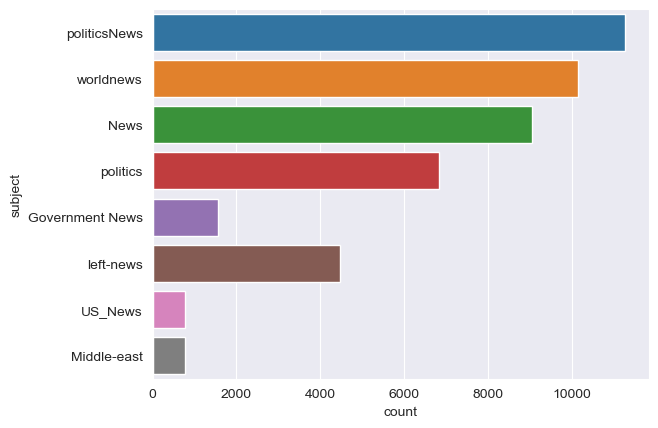

In [14]:
sns.countplot(data=df,
             y="subject")

plt.show()

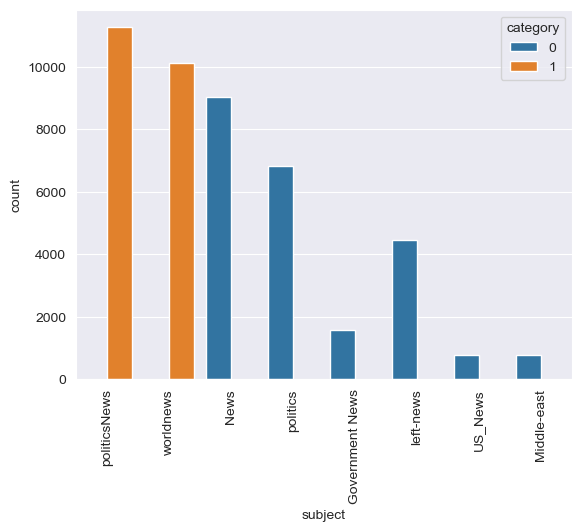

In [15]:
#3.真假新闻下的数量对比：
fig = sns.countplot(data=df,
             x="subject",
             hue="category")

fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

plt.show()

数据预处理

In [16]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Haijiang
[nltk_data]     Zeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# 设置停用词

stop = set(stopwords.words('english'))

punctuation = list(string.punctuation)
stop.update(punctuation)

In [18]:
# 文本解析

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# 去除特殊符号
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]','',text)

# 去除URL地址
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# 去除停用词
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# 删除噪音数据
def denoise_text(text):
    # 依次调用
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [19]:
df['text']=df['text'].apply(denoise_text)

词云图

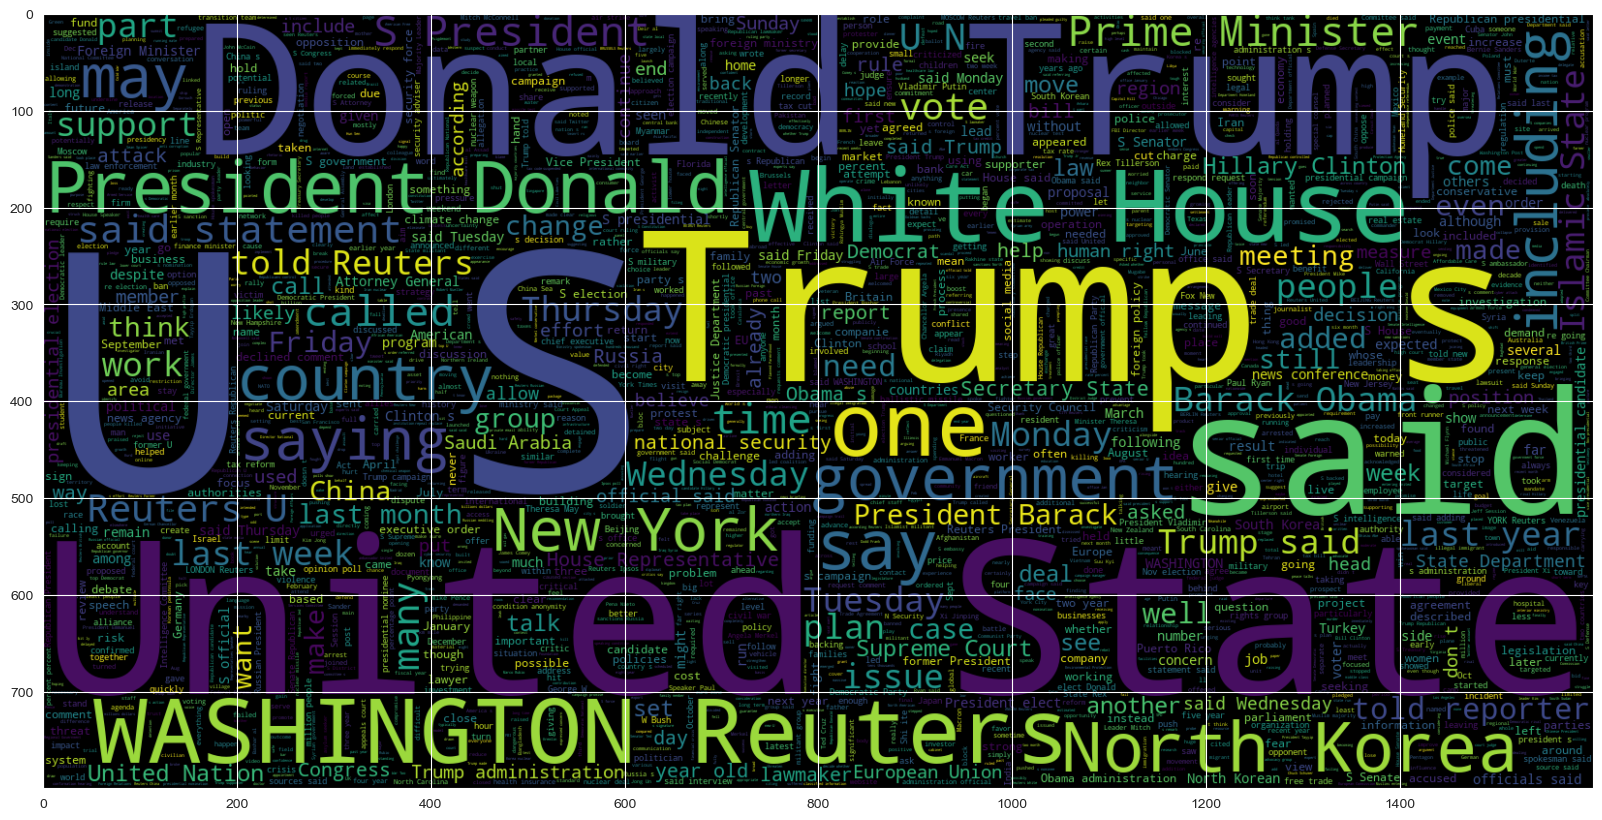

In [20]:
# 真实数据

plt.figure(figsize = (20,20)) 

wc = WordCloud(max_words = 2000 , 
               width = 1600 , 
               height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))

plt.imshow(wc , interpolation = 'bilinear')

plt.show()

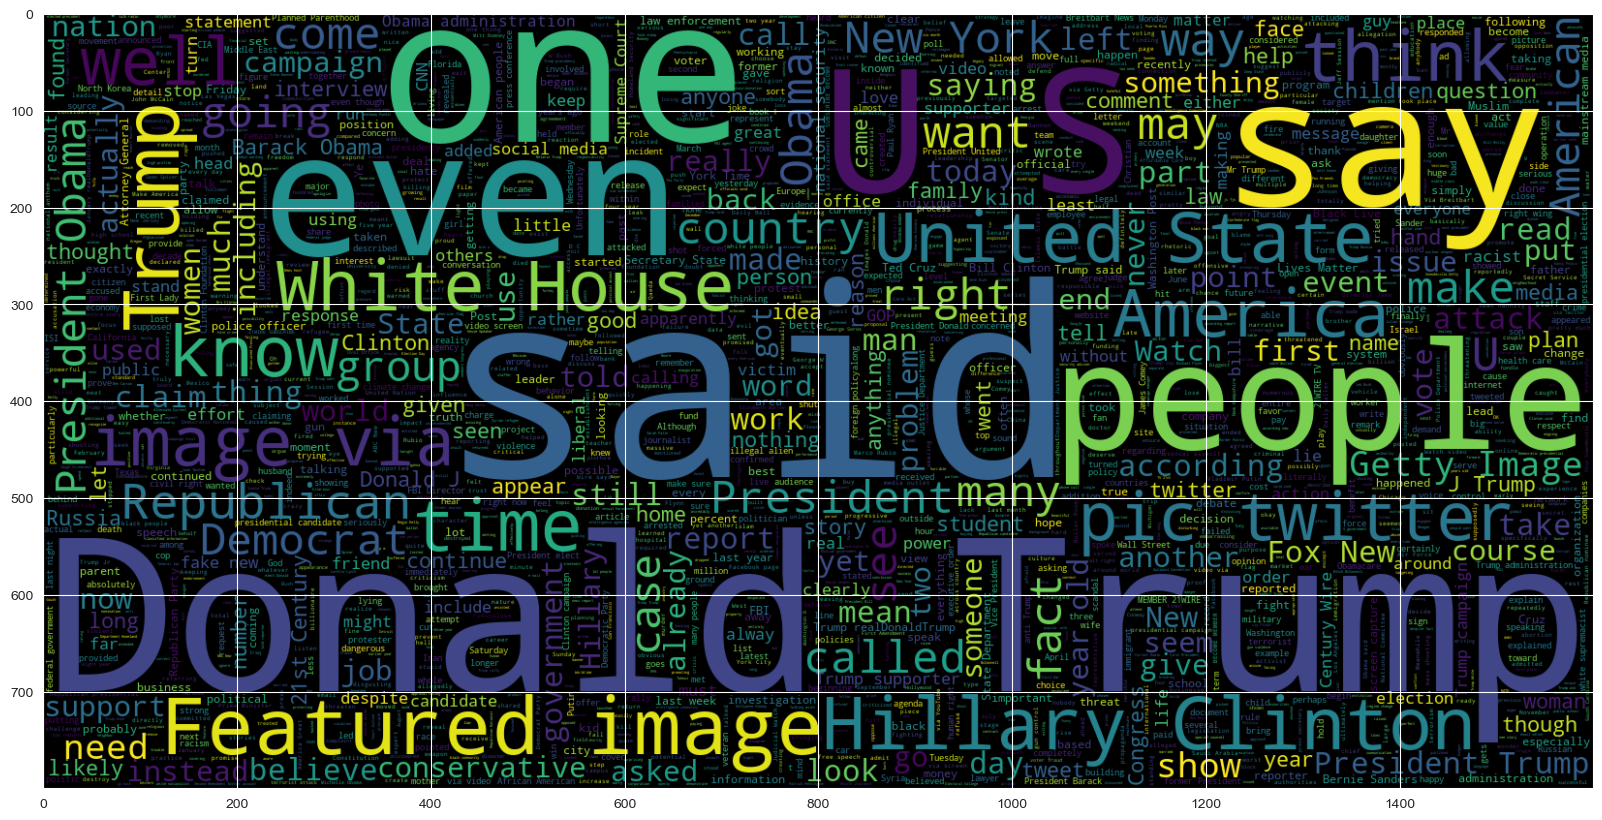

In [21]:
# 虚假数据

plt.figure(figsize = (20,20)) 

wc = WordCloud(max_words = 2000 , 
               width = 1600 , 
               height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))

plt.imshow(wc , interpolation = 'bilinear')

plt.show()

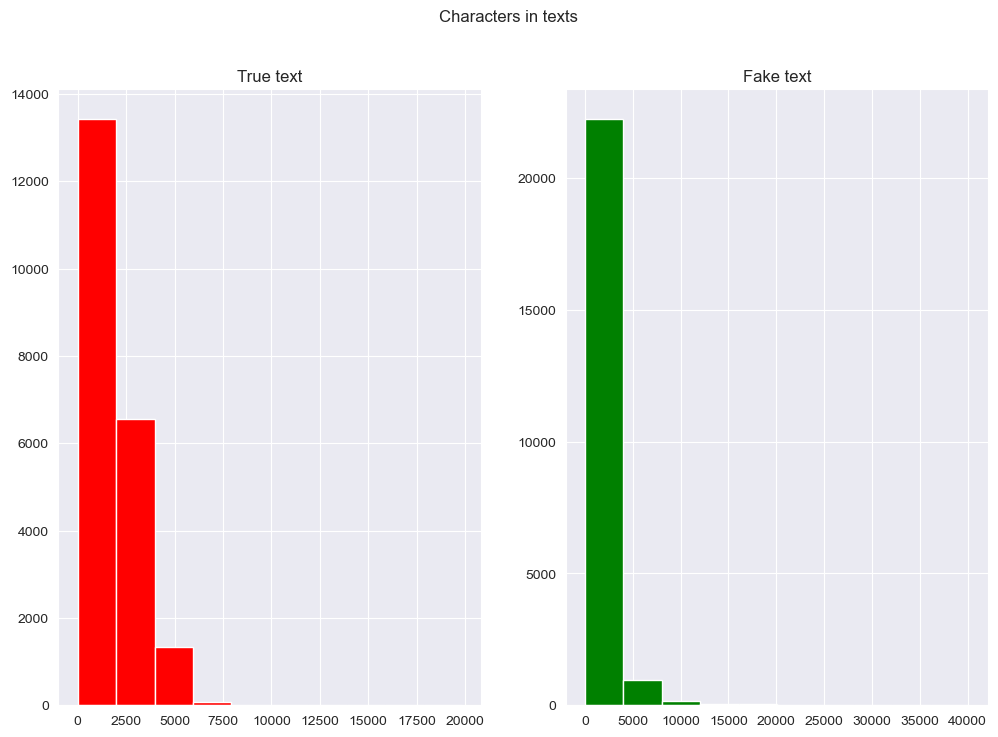

In [22]:
#真假新闻文本长度对比
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))

text_len=df[df['category']==1]['text'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('True text')

text_len=df[df['category']==0]['text'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')
plt.show()

Text(0.5, 0.98, 'Average word length in each text')

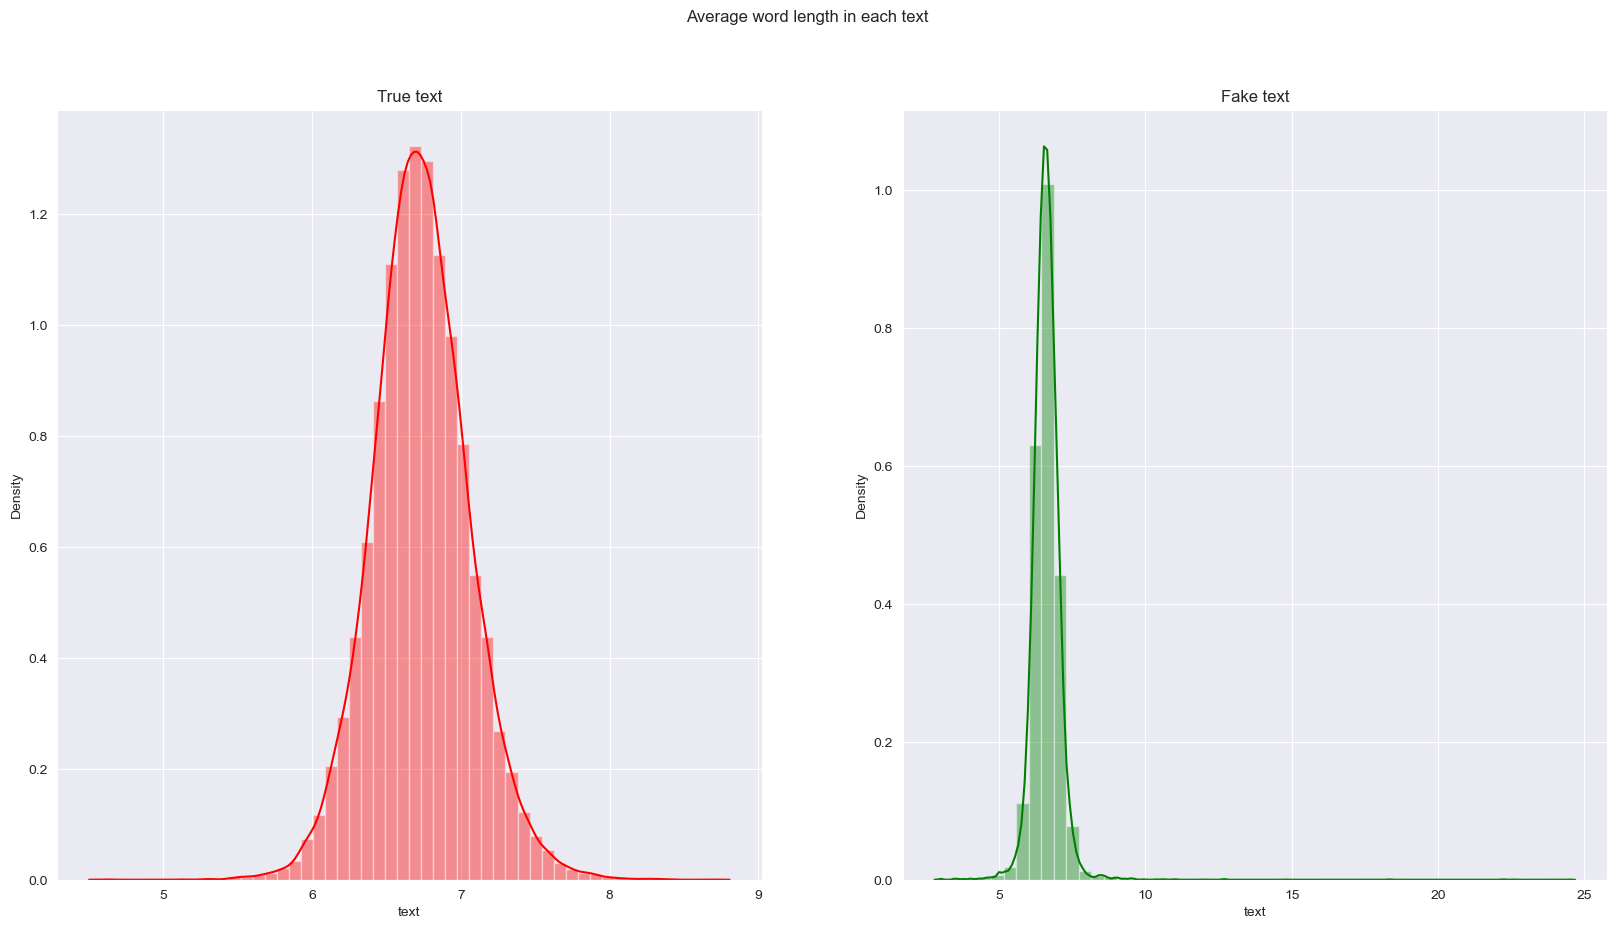

In [23]:
#文本中单词的平均长度对比
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

# True
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(word.map(lambda x: np.mean(x)),
             ax=ax1, 
             color='red')
ax1.set_title('True text')

# False
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),
             ax=ax2,
             color='green')
ax2.set_title('Fake text')

fig.suptitle('Average word length in each text')

生成语料

In [24]:
#文本切割
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) head conservative Republi...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) Transgender people allowe...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) special counsel investiga...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) Trump campaign adviser Ge...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) President Donald ...,politicsNews,"December 29, 2017",1


In [25]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():  # 先切割；生成的是列表
            words.append(j.strip())  # 再去除空格
            
    return words

# 调用函数
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [26]:
#语料计数
from collections import Counter

# 实例化
counter = Counter(corpus)
# 最靠前的10个
most_common = counter.most_common(10)  
most_common = dict(most_common)
most_common

{'Trump': 101305,
 'said': 93137,
 'would': 54354,
 'U.S.': 46126,
 'people': 32968,
 'President': 32303,
 'also': 30314,
 'one': 29296,
 'Donald': 27014,
 'said.': 26194}

In [27]:
#提取文本特征

from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(corpus, n, g):
    # CountVectorizer是属于常见的特征数值计算类，文本特征提取
    # 对于每一个训练文本，它只考虑每种词汇在该训练文本中出现的频率。
    # 会将文本中的词语转换为词频矩阵，它通过fit_transform函数计算各个词语出现的次数
    
    vec = CountVectorizer(ngram_range=(g,g)).fit(corpus)
    
    bag_of_words= vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
    return words_freq[:n]

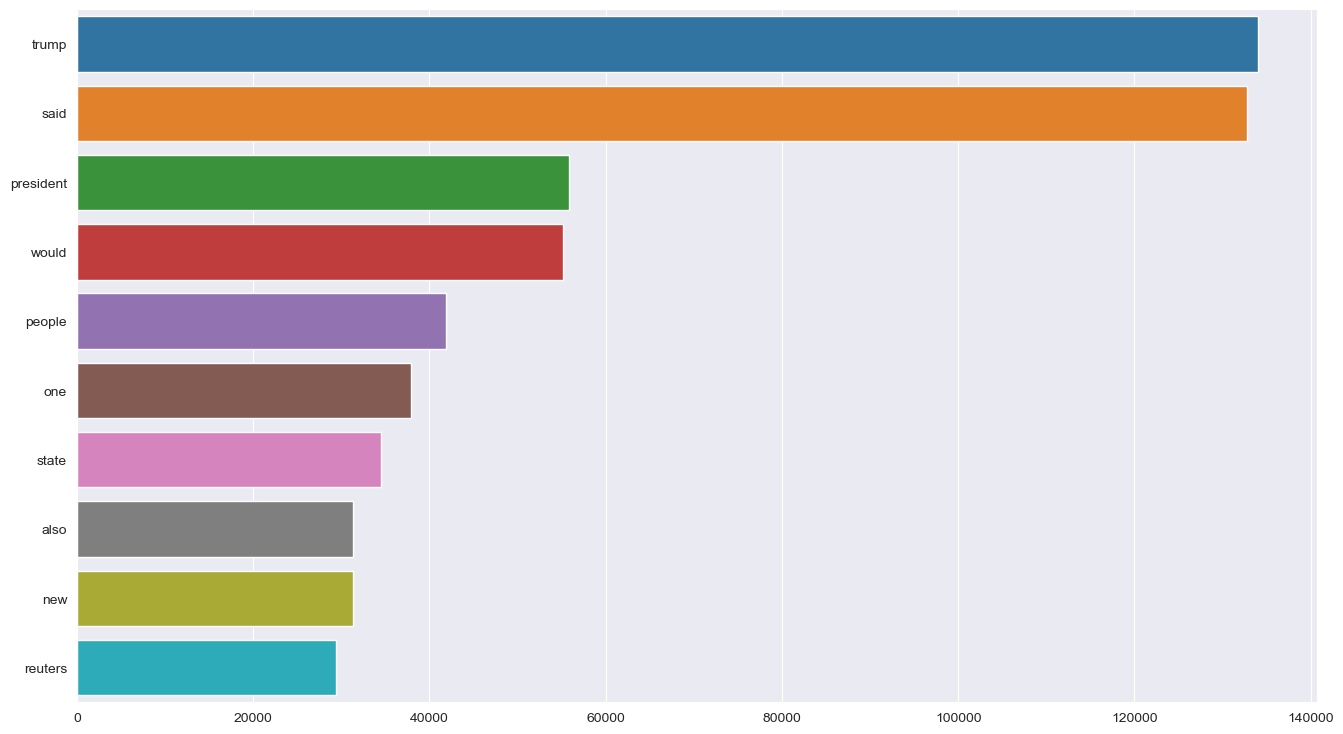

In [28]:
# N-gram语言模型分析
# 一元模型-Unigram Analysis
plt.figure(figsize = (16,9))

most_common_uni = get_top_text_ngrams(df.text,10,1)

most_common_uni = dict(most_common_uni)

sns.barplot(x=list(most_common_uni.values()),
            y=list(most_common_uni.keys()))

plt.show()


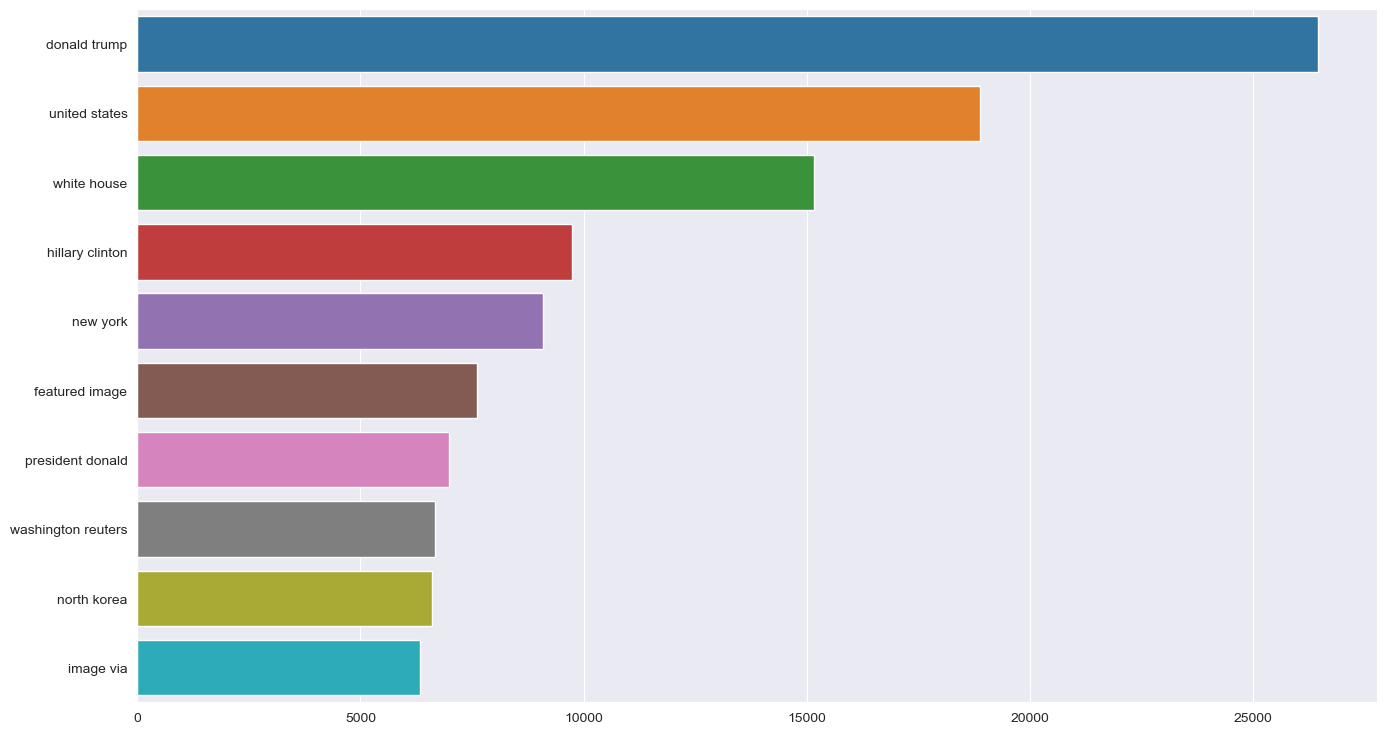

In [29]:
#二元模型-Bigram Analysis

plt.figure(figsize = (16,9))

most_common_bi = get_top_text_ngrams(df.text,10,2)

most_common_bi = dict(most_common_bi)

sns.barplot(x=list(most_common_bi.values()),
            y=list(most_common_bi.keys()))

plt.show()

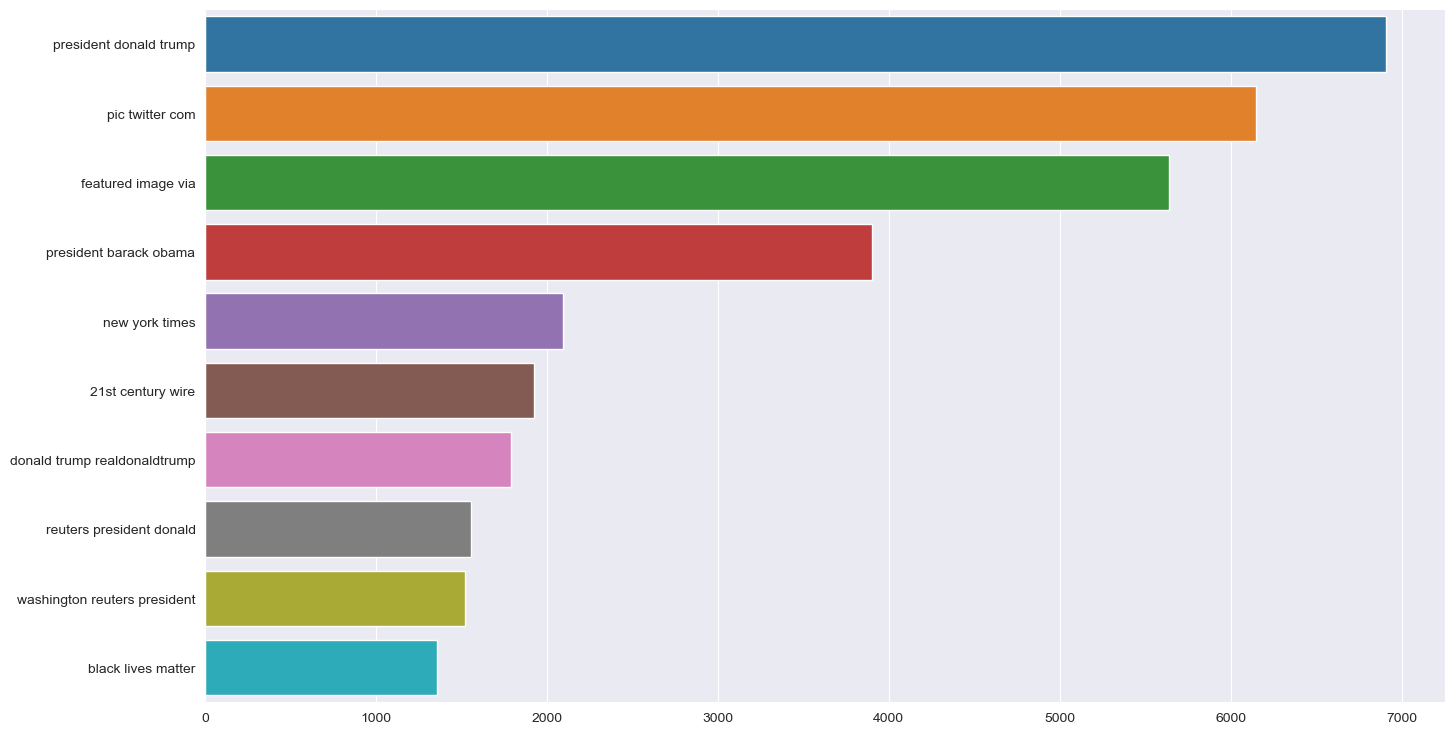

In [30]:
# 三元模型-Trigram Analysis

plt.figure(figsize = (16,9))

most_common_tri = get_top_text_ngrams(df.text,10,3)

most_common_tri = dict(most_common_tri)

sns.barplot(x=list(most_common_tri.values()),
            y=list(most_common_tri.keys()))

plt.show()


# 建模 

In [31]:
#数据集切分

x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

max_features = 10000
maxlen = 300

In [32]:
# 分词Tokenizer + 序列填充
# 分词
from keras.utils import pad_sequences
tokenizer = text.Tokenizer(num_words=max_features)
# 训练
tokenizer.fit_on_texts(x_train)
# 文本生成序列
tokenized_train = tokenizer.texts_to_sequences(x_train)
# 序列填充；保证长度相同
x_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [33]:
# 测试集的填充

tokenized_test = tokenizer.texts_to_sequences(x_test)

X_test = pad_sequences(tokenized_test, maxlen=maxlen)

词向量训练-Glove使用
官网文档：https://nlp.stanford.edu/projects/glove/

知乎好文：https://zhuanlan.zhihu.com/p/50946044

In [34]:
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

In [55]:
# 计算单词间的相关性
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,  encoding='UTF-8'))

In [36]:
all_embs = np.stack(embeddings_index.values())

emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))  # 初始值设置

for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

# 模型训练

In [37]:
# 模型参数

batch_size = 256
epochs = 5
embed_size = 100

In [38]:
# 学习率设置

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience = 2,
    verbose=1,
    factor=0.5, 
    min_lr=0.00001
)

In [39]:
# Keras模型训练

model = Sequential()

model.add(Embedding(max_features,   # Embedding层
                    output_dim=embed_size, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))

model.add(LSTM(units=128 , 
               return_sequences = True , 
               recurrent_dropout = 0.25 , 
               dropout = 0.25))

model.add(LSTM(units=64, 
               recurrent_dropout = 0.1 , 
               dropout = 0.1))

model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [40]:
model.summary()  # 模型概要

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [41]:
# 模型训练

history = model.fit(x_train, 
                    y_train,
                    batch_size = batch_size , 
                    validation_data = (X_test,y_test) , 
                    epochs = epochs , 
                    callbacks = [learning_rate_reduction])

Epoch 1/5
132/132 [==============================] - 847s 6s/step - loss: 0.2950 - accuracy: 0.8741 - val_loss: 0.1514 - val_accuracy: 0.9461 - lr: 0.0010
Epoch 2/5
132/132 [==============================] - 992s 8s/step - loss: 0.1388 - accuracy: 0.9493 - val_loss: 0.0759 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 3/5
132/132 [==============================] - 1062s 8s/step - loss: 0.0886 - accuracy: 0.9690 - val_loss: 0.0530 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 4/5
132/132 [==============================] - 1086s 8s/step - loss: 0.0773 - accuracy: 0.9752 - val_loss: 0.0956 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/5
132/132 [==============================] - 1139s 9s/step - loss: 0.0561 - accuracy: 0.9817 - val_loss: 0.0340 - val_accuracy: 0.9901 - lr: 0.0010


模型分析

In [42]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

1053/1053 [==============================] - 50s 48ms/step - loss: 0.0299 - accuracy: 0.9916
Accuracy of the model on Training Data is -  99.15956258773804 %


In [43]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

351/351 [==============================] - 17s 49ms/step - loss: 0.0340 - accuracy: 0.9901
Accuracy of the model on Testing Data is -  99.01113510131836 %


结果可视化

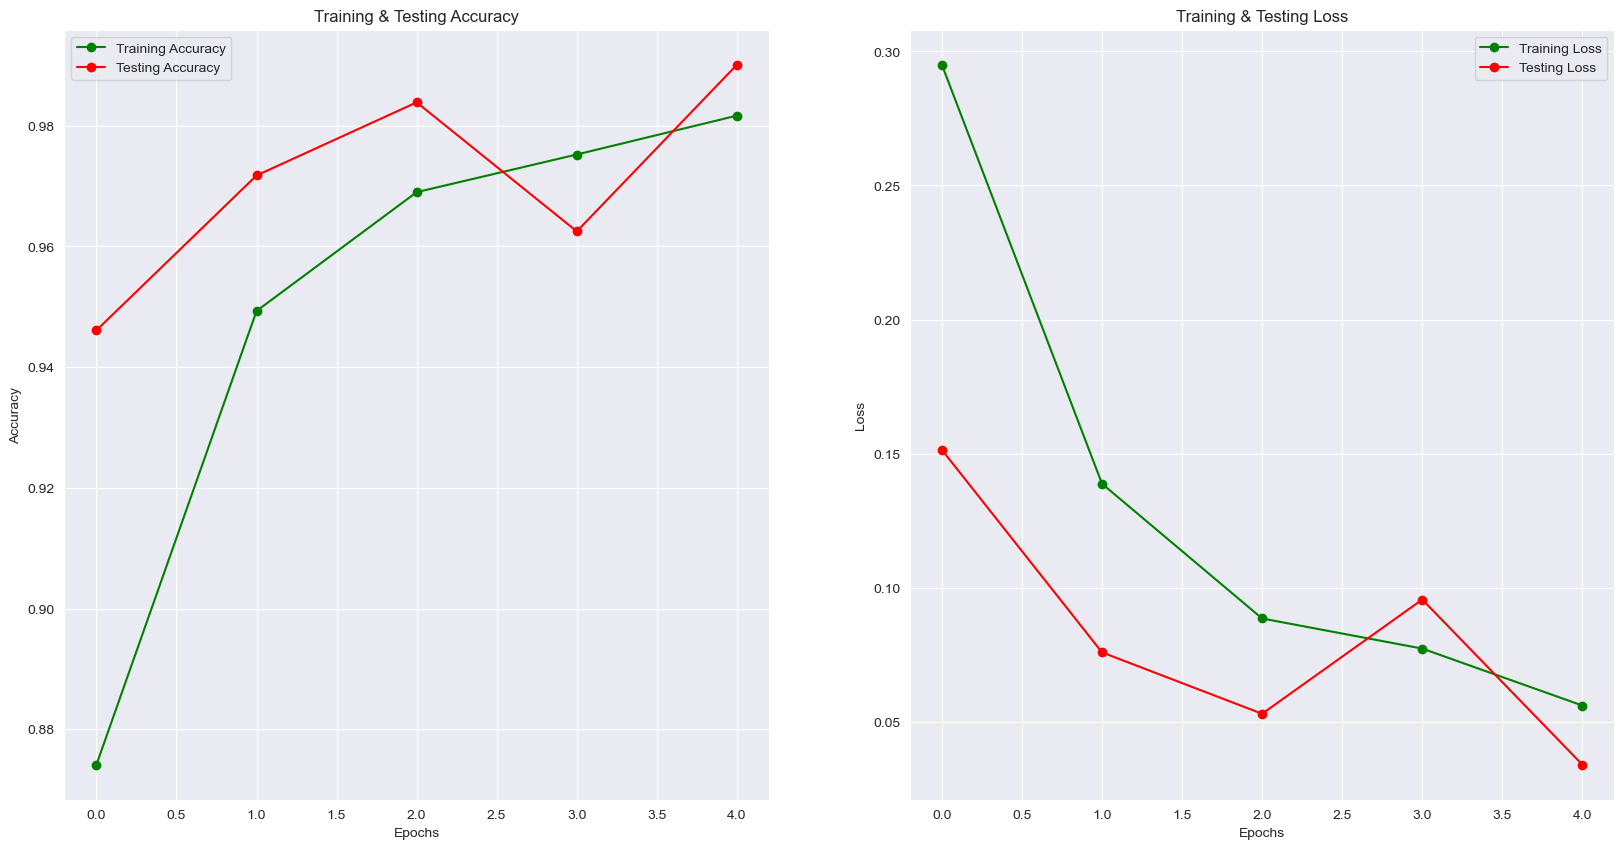

In [45]:
# 前5个epochs

epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

模型预测

In [46]:
len(X_test)

11225

In [47]:
pred = model.predict(X_test)

351/351 [==============================] - 15s 41ms/step


In [63]:
y_pred=[]
for i in pred:
    y_pred.append(int(i[0]+0.5))

In [64]:
# 分类报告结果

print(classification_report(y_test, y_pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5981
    Not Fake       0.99      0.99      0.99      5244

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [65]:
# 混淆矩阵

cm = confusion_matrix(y_test,y_pred)
cm

array([[5905,   76],
       [  35, 5209]], dtype=int64)

In [66]:
cm = pd.DataFrame(cm , 
                  index = ['Fake','Original'] , 
                  columns = ['Fake','Original'])

Text(97.72222222222221, 0.5, 'Actual')

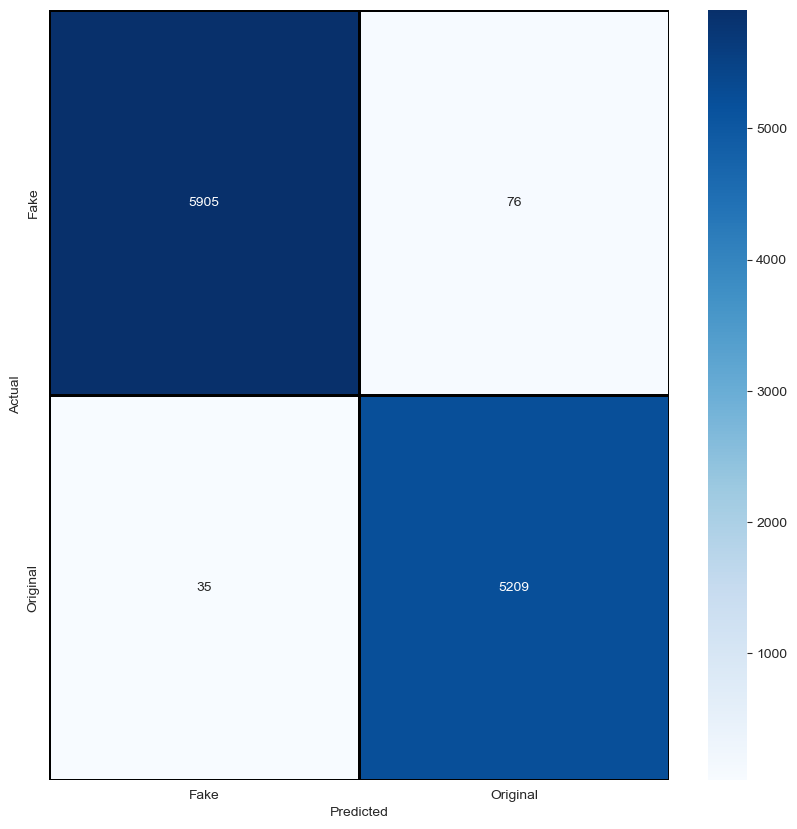

In [67]:
# 可视化

plt.figure(figsize = (10,10))
sns.heatmap(cm,
            cmap= "Blues", 
            linecolor = 'black' , 
            linewidth = 1 , 
            annot = True,
            fmt='' , 
            xticklabels = ['Fake','Original'] , 
            yticklabels = ['Fake','Original'])

plt.xlabel("Predicted")
plt.ylabel("Actual")